In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from collections import defaultdict

def func(x, a, koff, c):
    return a * np.exp(-koff * x) + c

def fitKinetics(df, max_fev=20000):
    df_copy = df.copy()
    time = df_copy['timepoint']
    ratio = df_copy['R_bSub']
    
    popt, pcov = curve_fit(func, time, ratio, maxfev = max_fev)
    df_copy['R_Start_fitted'] = popt[0]
    df_copy['koff_fitted'] = popt[1]
    df_copy['asymptote_fitted'] = popt[2]
    return df_copy

def get_kinetic_df(rawdata_df, oligos, out_file, kinetic_func=fitKinetics):
    temp_df = rawdata_df[rawdata_df['timepoint'] <= 16]
    kinetic_df = temp_df.groupby(by=['Chamber_Index'])
    kinetic_df = kinetic_df.filter(lambda x: len(x) == 9)
    kinetic_df = kinetic_df.groupby(by=['Chamber_Index'])
    kinetic_df = kinetic_df.apply(kinetic_func)
    kinetic_df = kinetic_df.merge(oligonames[['Oligo_Identity','New_title', 'Category']], on='Oligo_Identity', how='left')
    
    kinetic_df = kinetic_df.merge(Kd_data[['Oligo_Identity', 'Kd_mean', 'Kd_sdev']], on='Oligo_Identity', how='left')
    kinetic_df['kon_calc'] = kinetic_df['koff_fitted']/(kinetic_df['Kd_mean']*10**(-9))
    
    return kinetic_df

def get_dataset_rmse(df):
    diff = np.array(df['R_bSub'] - func(df['timepoint'], df['R_Start_fitted'], df['koff_fitted'], df['asymptote_fitted']))
    diff = diff[~np.isnan(diff)]
    return np.sqrt(np.mean(diff**2))/(df['R_Start_fitted']+df['asymptote_fitted'])

def plot_kinetic_curves(kinetic_df, order, out_file):
    ncol = 4
    num_oligos = len(order)
    nrow = int(np.ceil(num_oligos/ncol))
    fig = plt.figure(figsize=(5*ncol,5*nrow))
    ymax = np.max(kinetic_df['R_bSub'])
    for i, oligo in enumerate(order):
        ax = fig.add_subplot(nrow,ncol,i+1)
        oligo_id = list(kinetic_df[kinetic_df['New_title'] == oligo]['Oligo_Identity'])[0]
        df_to_plot = kinetic_df[kinetic_df['Oligo_Identity'] == oligo_id]
        time_range = np.arange(df_to_plot['timepoint'].min(),df_to_plot['timepoint'].max()+2,0.5)
        for ch in df_to_plot['Chamber_Index'].unique():
            temp = df_to_plot[df_to_plot['Chamber_Index']==ch]
            ax.scatter(temp['timepoint'], temp['R_bSub'], c='C0')
        ax.set_ylim((-0.1,1.1*ymax))
        if i % ncol == 0:
            ax.set_ylabel('DNA/TF ratio', fontsize=18)
        if num_oligos - i - 1 < ncol: 
            ax.set_xlabel('time (s)', fontsize=18)
        ax.tick_params(labelsize=14)
        ax.set_title(oligo, fontsize=20)
    
    fig.tight_layout(w_pad=2.5)
    fig.savefig(out_file)

In [2]:
prefix = '181206_d1_MAX_library1_WGE_'
duty_cycle = 2

oligonames = pd.read_csv('../library1/library1_names_sequences.csv')
library1_order = np.load('../library1/library1_order.npy')[:-4] # last four oligos have no motif and are discarded

Kd_data = pd.read_csv('../data_output/'+prefix+'GFIT_output_culled.csv', index_col=0)

header = '../data_output_kinetics/'+prefix

In [3]:
Kd_data

,Oligo_Identity,New_title,Kd_mean,Kd_sdev
0,1,Motif + repeat 1,335.989650,41.993262
1,2,Motif + short repeat 3,289.844216,29.078523
2,3,Mutated motif + random 1,4935.482744,613.320671
3,4,No motif + random 1,12491.897292,2336.505502
5,6,Motif + short repeat 4,397.654383,49.835415
6,7,Mutated motif + random 2,4545.007296,671.845452
7,8,No motif + random 2,11861.388216,2212.675717
8,9,Motif + repeat 3,269.292731,36.752355
9,10,Motif + short repeat 5,466.509810,43.773695
10,11,Mutated motif + random 3,5022.144206,568.729074


In [4]:
#pull in postwash GFP data (KINETIC TRACE)
postwash_GFP = pd.read_csv(prefix+'postwashgfp_kinetics.csv')
postwash_GFP = postwash_GFP.add_suffix('_postwashGFP')
postwash_GFP.rename(columns={'postwash_images_postwashGFP':'step','x_postwashGFP': 'x','y_postwashGFP': 'y','id_postwashGFP': 'id'}, inplace=True)
postwash_GFP['Chamber_Index'] = postwash_GFP['x'].map(str)+','+postwash_GFP['y'].map(str)

#pull in postwash CY5 data (KINETIC TRACE)
postwash_Cy5 = pd.read_csv(prefix+'postwashcy5_kinetics.csv')
postwash_Cy5 = postwash_Cy5.add_suffix('_postwashCy5')
postwash_Cy5.rename(columns={'postwash_images_postwashCy5':'step','x_postwashCy5': 'x','y_postwashCy5': 'y','id_postwashCy5': 'id'}, inplace=True)
postwash_Cy5['Chamber_Index'] = postwash_Cy5['x'].map(str)+','+postwash_Cy5['y'].map(str)

In [5]:
# now perform merging: common columns are x, y, id, and step
rawdata_df = pd.merge(postwash_GFP,postwash_Cy5, how='left',on=['id','step','x','y','Chamber_Index'])

#now add some paramters of the kinetic acquisition and collect R_bSub values...
rawdata_df['duty_cycle'] = duty_cycle
rawdata_df['tau'] = 1/rawdata_df['duty_cycle']
rawdata_df['timepoint'] = rawdata_df['step'] * rawdata_df['duty_cycle'] 
rawdata_df['R_bSub'] = rawdata_df['summed_button_BGsub_postwashCy5']/rawdata_df['summed_button_BGsub_postwashGFP'];
rawdata_df['timepoint'] = rawdata_df['step'] * rawdata_df['duty_cycle'] 

#drop all columns with '0_0' id
rawdata_df = rawdata_df[rawdata_df['id']!='0_0']

#split the id into two columns one is the oligo identity and the other is the oligo concentration...
rawdata_df['Oligo_Identity'] = rawdata_df['id'].apply(lambda x: int(x.split('_')[0]))
rawdata_df['Oligo_Concentration'] = rawdata_df['id'].apply(lambda x: int(x.split('_')[1]))
rawdata_df_original = rawdata_df

In [6]:
rawdata_df_filter = rawdata_df[rawdata_df['R_bSub'] > 0]

bad_columns = [1,28]
bad_rows = [1,2,3,4,5]
rawdata_df_filter = rawdata_df_filter[~rawdata_df_filter['x'].isin(bad_columns)]
rawdata_df_filter = rawdata_df_filter[~rawdata_df_filter['y'].isin(bad_rows)]


rawdata_df_filter = rawdata_df_filter[rawdata_df_filter['summed_button_BGsub_postwashGFP'] < 2.75e6]
# rawdata_df_filter = rawdata_df_filter[rawdata_df_filter['summed_button_BGsub_postwashGFP'] > 1.6e6]

<BarContainer object of 8 artists>

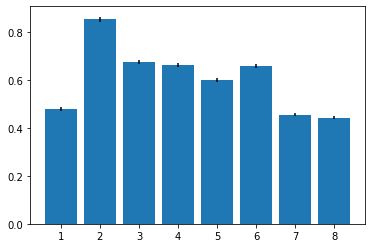

In [7]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)

y = rawdata_df_original.groupby(by='Oligo_Concentration')['R_bSub'].mean()
yerr = rawdata_df_original.groupby(by='Oligo_Concentration')['R_bSub'].sem()

ax.bar(x=np.arange(8)+1, height=y, yerr=yerr)

In [8]:
# define output files
fit_out_file = header + 'kinetics_fit.csv'
df_out_file = header + 'kinetics_df.csv'
curve_out_file = header + 'dissociation_rawdata.pdf'

# data setup 
rawdata_df = rawdata_df_filter
high_conc = [2,3,4]
rawdata_df = rawdata_df[rawdata_df['Oligo_Concentration'].isin(high_conc)]

# calculates kinetic parameters and plots data
kinetic_df = get_kinetic_df(rawdata_df, library1_order, fit_out_file)
kinetic_df.to_csv(df_out_file, index=False)

/usr/local/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


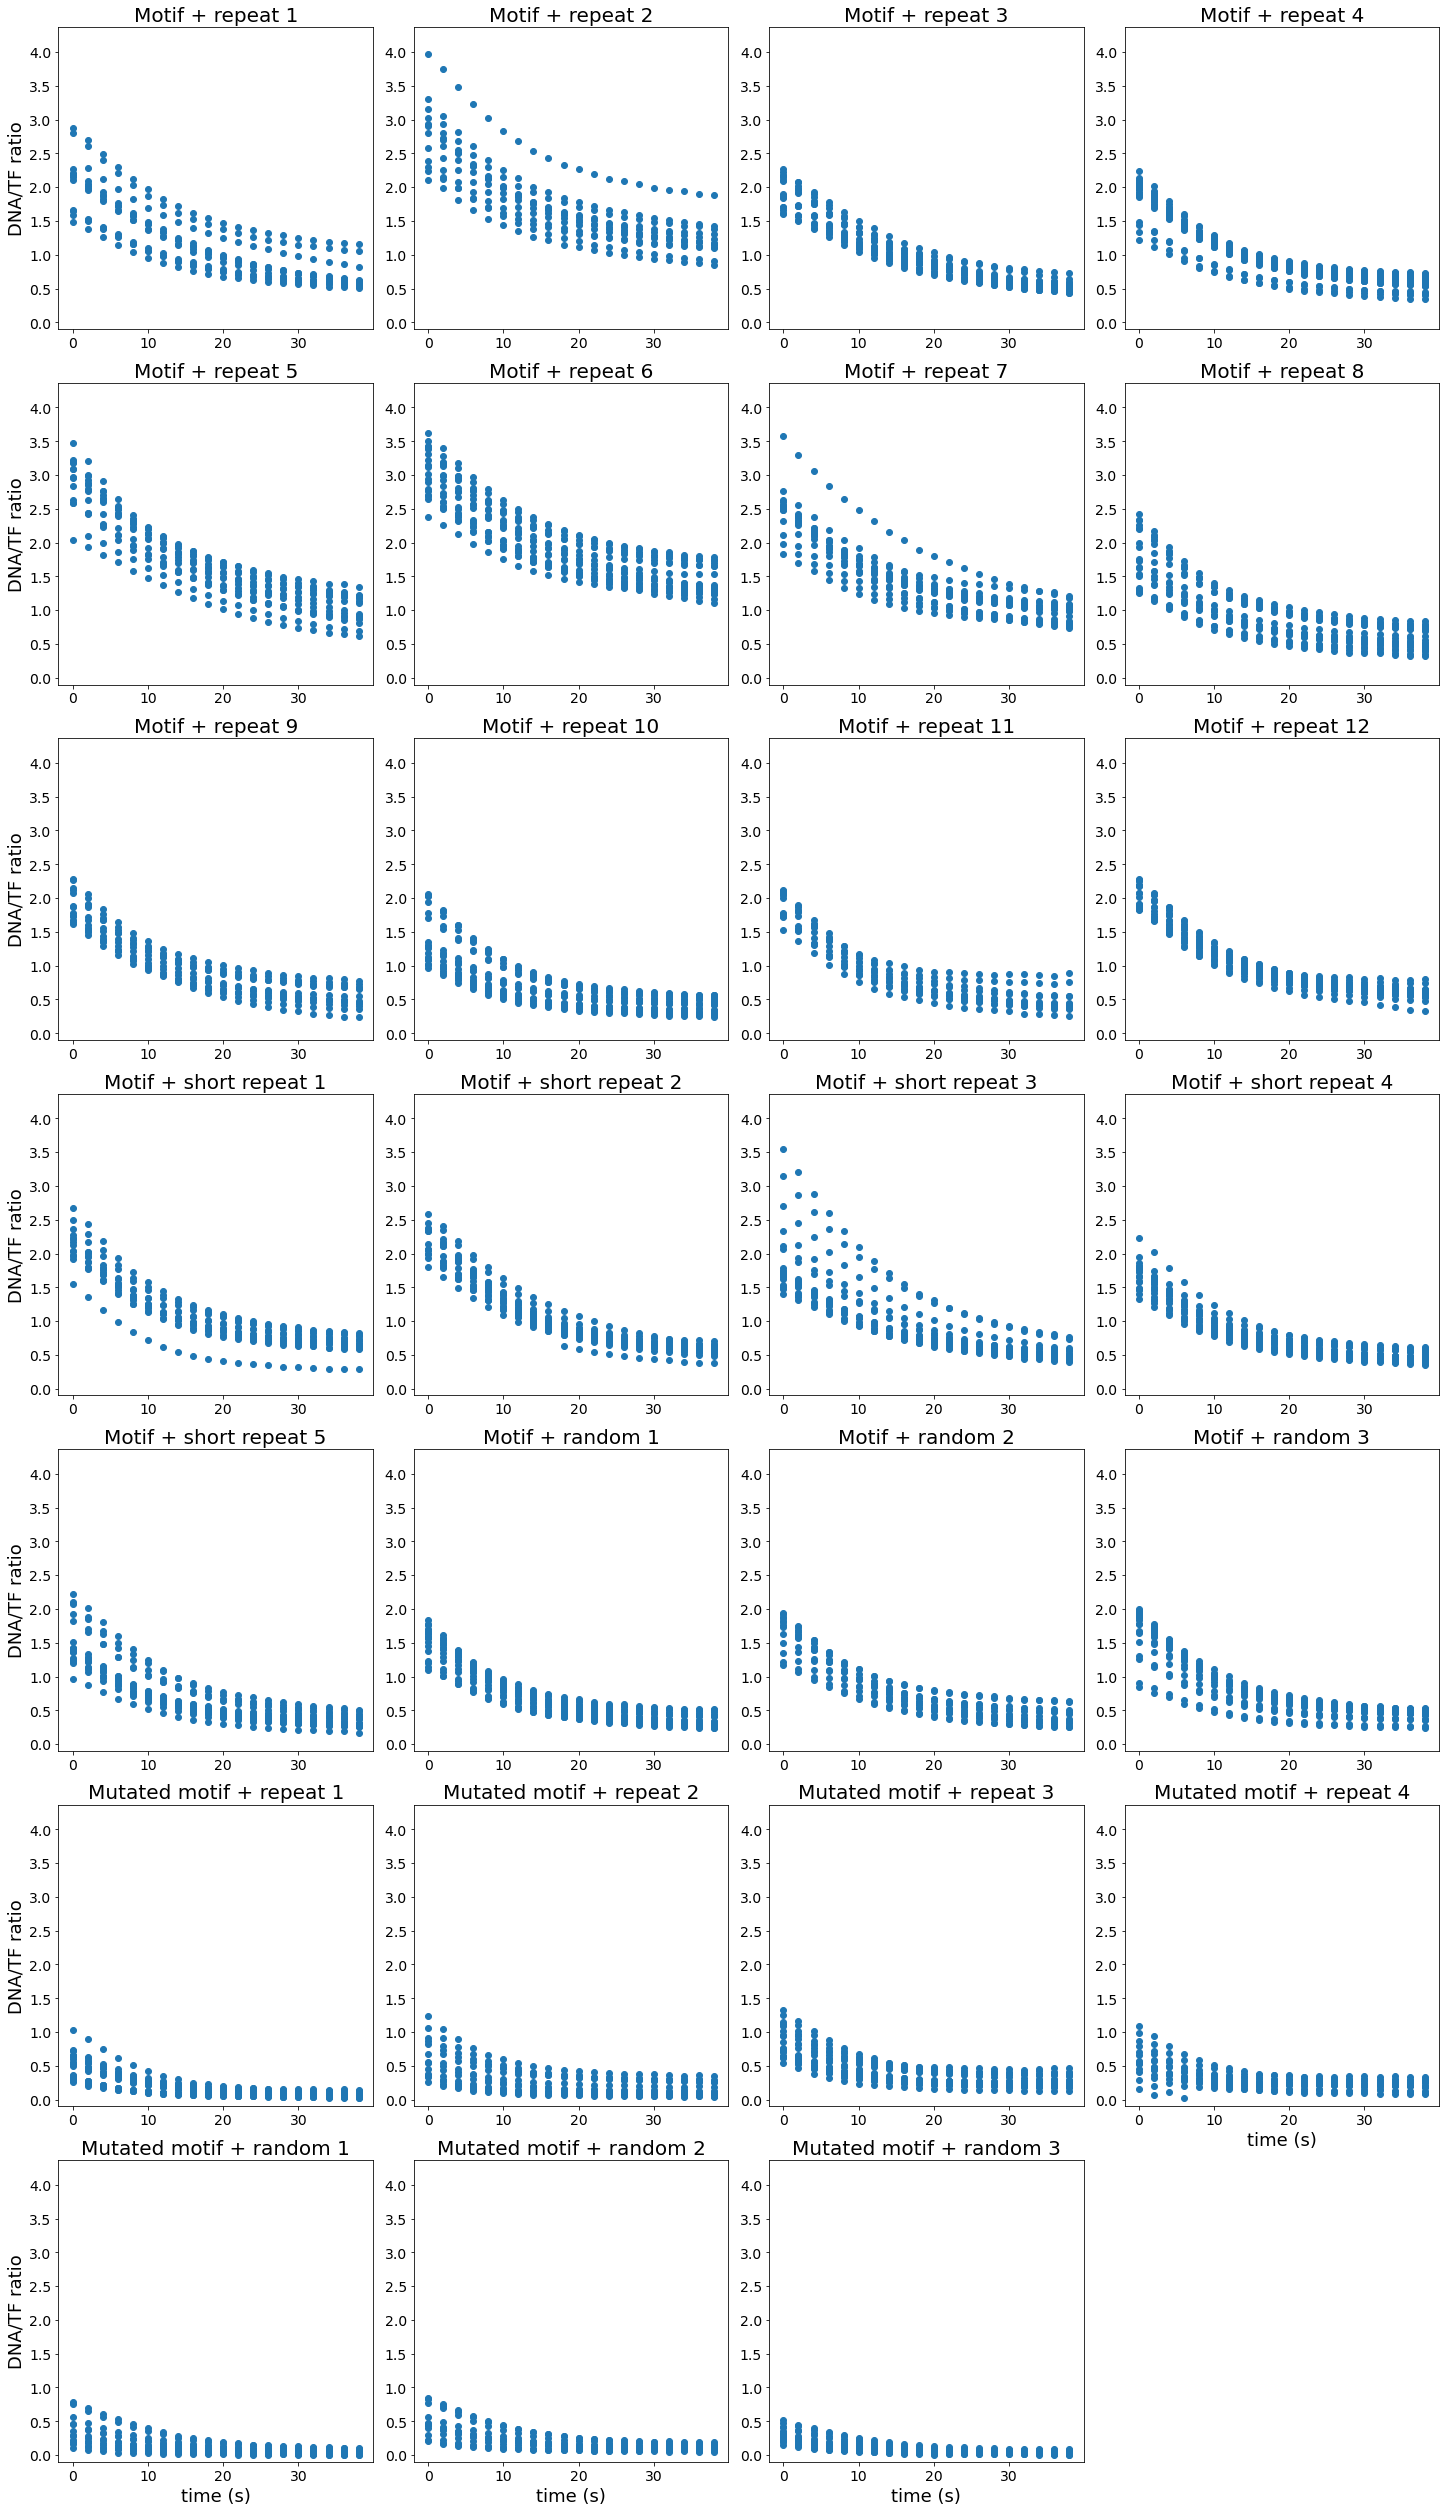

In [9]:
plotting_df = rawdata_df.merge(oligonames[['Oligo_Identity','New_title', 'Category']], on='Oligo_Identity', how='left')

plot_kinetic_curves(plotting_df, library1_order, curve_out_file)